In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.10

In [12]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [3]:
import numpy as np
import pandas as pd
import os
import re  # regex
import matplotlib.pyplot as plt
from IPython import display
from struct import unpack
from datetime import datetime
from keras.layers import LSTM, Dense,Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
import math
import timeit
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pickle
import glob2
%matplotlib inline

In [4]:
# Đọc dữ liệu
fall_dataset = pd.read_csv("/content/drive/MyDrive/Fall_detection/LSTM/FALL.txt")
not_fall_dataset = pd.read_csv("/content/drive/MyDrive/Fall_detection/LSTM/NOT_FALL.txt")

X = []
y = []
no_of_timesteps = 10


not_fall_data = not_fall_dataset.iloc[:,1:].values
n_sample = len(not_fall_data)
for i in range(no_of_timesteps, n_sample):
    X.append(not_fall_data[i-no_of_timesteps:i,:])
    y.append([1,0])

fall_data = fall_dataset.iloc[:,1:].values
n_sample = len(fall_data)
for i in range(no_of_timesteps, n_sample):
    X.append(fall_data[i-no_of_timesteps:i,:])
    y.append([0,1])


X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

(31520, 10, 52) (31520, 2)
X_train.shape = (22064, 10, 52)
y_train.shape = (22064, 2)
X_val.shape = (3152, 10, 52)
y_val.shape = (3152, 2)
X_test.shape = (6304, 10, 52)
y_test.shape = (6304, 2)


In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def custom_optimizer_init_fn():
    learning_rate = 1e-5
    return tf.keras.optimizers.Adam(learning_rate)

In [6]:
print((X.shape[1], X.shape[2]))

(10, 52)


In [7]:
model  = Sequential()
model.add(LSTM(units = 256, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 10, activation="sigmoid"))
model.add(Dense(units = 2, activation="softmax"))
optimize = custom_optimizer_init_fn()
# model.compile(optimizer=optimize, metrics = ['accuracy'], loss = "binary_crossentropy")
model.compile(optimizer=optimize, metrics = METRICS, loss = "binary_crossentropy")
model.summary ()
# model.fit(X_train, y_train, epochs=150, batch_size=300, validation_data=(X_test, y_test))
batch_size = 500
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
model.save("/content/drive/MyDrive/Fall_detection/LSTM/model_10_new.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           316416    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            35800     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [13]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()


# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="frozen_graph.pb",
                  as_text=False)

'./frozen_models/frozen_graph.pb'

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


def get_fashion_mnist_data():

    fashion_mnist = keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images,
                                   test_labels) = fashion_mnist.load_data()
    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
        "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    train_images = train_images.astype(np.float32) / 255.0
    test_images = test_images.astype(np.float32) / 255.0

    return (train_images, train_labels), (test_images, test_labels)


def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    if print_graph == True:
        print("-" * 50)
        print("Frozen model layers: ")
        layers = [op.name for op in import_graph.get_operations()]
        for layer in layers:
            print(layer)
        print("-" * 50)

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))

In [ ]:
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                    logdir="./frozen_models",
                    name="complex_frozen_graph.pb",
                    as_text=False)

# Load frozen graph using TensorFlow 1.x functions
with tf.io.gfile.GFile("/content/frozen_models/frozen_graph.pb", "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

# Wrap frozen graph to ConcreteFunctions
frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                inputs=["x:0"],
                                outputs=["Identity:0"],
                                print_graph=True)

In [24]:
import time
start = time.time()
i = 80
input_predict = 1*X_test[i]
input_predict_expand = input_predict[np.newaxis,...]
input_predict_expand = np.array(input_predict_expand,np.float32)
predicted_class = model.predict(input_predict_expand)
print("predicted_class", predicted_class)
print(time.time()-start)
start = time.time()
i = 80
input_predict = 1*X_test[i]
input_predict_expand = input_predict[np.newaxis,...]
input_predict_expand = np.array(input_predict_expand,np.float32)
# Get predictions for test images
frozen_graph_predictions = frozen_func(x=tf.constant(input_predict_expand))[0]

# Print the prediction for the first image
print(frozen_graph_predictions[0].numpy())
print(time.time()-start)


1/1 [==============================] - 0s 36ms/step
predicted_class [[0.69901884 0.30098113]]
0.09092998504638672
[0.69901884 0.30098113]
0.01273965835571289


Done!


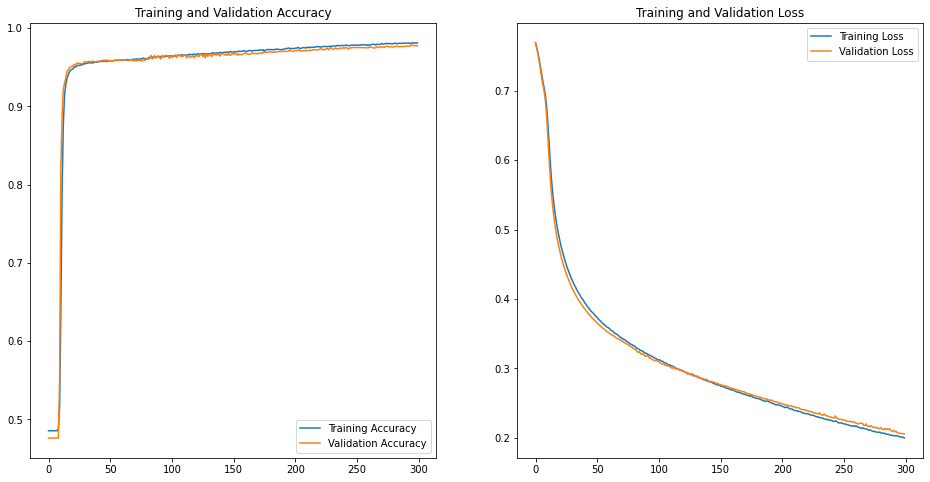

In [ ]:

print('Done!')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# list of colors for plotting
COLOR_LIST = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#58e03d']

In [ ]:
def plot_distribution(data_y_train, data_y_val, data_y_test):
    """
    Plot data distribution for training and test set
    :param np_array<int>[n,] data_y_train: labels of training set
    :param np_array<int>[n,] data_y_test: labels of test set
    :return: None
    """

    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Count', ylim=(0, 12500))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=3, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 4))

    # plot distribution for training set
    count1 = 0
    count0 = 0
    for el in data_y_train:
      if el[0] == 0:
        count1 +=1
      else:
        count0 += 1
    print("Number of data FALL in TRAINING SET:", count1)
    print("Number of data NOT FALL in TRAINING SET:", count0)
    print("--------------------------------------------------")
    axes[0].bar(["NOT FALL", "FALL"], [count0, count1], color=COLOR_LIST)
    axes[0].set_title('Training Set')

    # plot distribution for validation set
    count1 = 0
    count0 = 0
    for el in data_y_val:
      if el[0] == 0:
        count1 +=1
      else:
        count0 += 1
    print("Number of data FALL in VALIDATION SET:", count1)
    print("Number of data NOT FALL in VALIDATION SET:", count0)
    print("--------------------------------------------------")
    axes[1].bar(["NOT FALL", "FALL"], [count0, count1], color=COLOR_LIST)
    axes[1].set_title('Validation Set')

    # plot distribution for test set
    count1 = 0
    count0 = 0
    for el in data_y_test:
      if el[0] == 0:
        count1 +=1
      else:
        count0 += 1
    print("Number of data FALL in TEST SET:", count1)
    print("Number of data NOT FALL in TEST SET:", count0)
    unique_list, count_list = np.unique(data_y_test, return_counts=True)
    axes[2].bar(["NOT FALL", "FALL"], [count0, count1], color=COLOR_LIST)
    axes[2].set_title('Test Set')
    plt.show()

Number of data FALL in TRAINING SET: 11352
Number of data NOT FALL in TRAINING SET: 10712
--------------------------------------------------
Number of data FALL in VALIDATION SET: 1651
Number of data NOT FALL in VALIDATION SET: 1501
--------------------------------------------------
Number of data FALL in TEST SET: 3197
Number of data NOT FALL in TEST SET: 3107


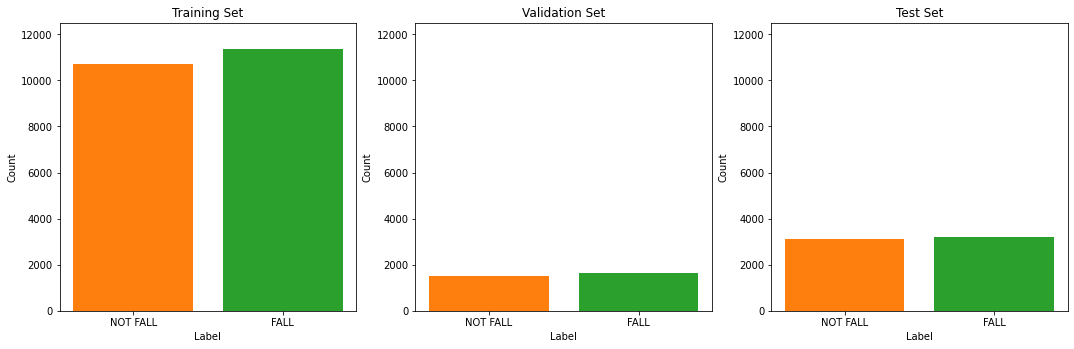

In [ ]:
plot_distribution(y_train, y_val, y_test)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Fall_detection/LSTM/model_10.h5')


In [16]:
i = 80
input_predict = 1*X_test[i]
input_predict_expand = input_predict[np.newaxis,...]
input_predict_expand = np.array(input_predict_expand,np.float32)
predicted_class = model.predict(input_predict_expand)
print("predicted_class", np.argmax(predicted_class))
print("y_test", y_test[i])

print(input_predict)
print(input_predict_expand)

1/1 [==============================] - 0s 36ms/step
predicted_class 0
y_test [1 0]
[[ 0.45040244  0.12683667 -0.23346505  0.9998793   0.51102424  0.21840112
  -0.18274941  0.99999589  0.43523711  0.22252528  0.04713761  0.99933529
   0.52633607  0.37399122 -0.1789006   0.99761885  0.43041959  0.36915529
   0.12900609  0.13864078  0.52016419  0.51509851 -0.22828415  0.99300921
   0.41074777  0.48362523  0.03764508  0.32151592  0.49532166  0.51375496
  -0.07478383  0.99986529  0.44875723  0.51041967  0.07488959  0.9993735
   0.50171477  0.70833474 -0.10873123  0.99127328  0.44832665  0.68976635
   0.17503829  0.88526219  0.50045907  0.90495574 -0.02245915  0.98526186
   0.45790726  0.84451991  0.37922615  0.92766619]
 [ 0.45234817  0.12724455 -0.22908473  0.99988788  0.51164514  0.22065619
  -0.15687872  0.99999607  0.42641583  0.23296642  0.04008861  0.99937946
   0.52901208  0.37254903 -0.14996196  0.99768454  0.42492741  0.37370831
   0.11118631  0.17211299  0.52345663  0.51262856 -0.

In [ ]:
def predicted(model, data_x):
    predicted_list = []
    for i in range(len(data_x)):
      input_predict = 1*data_x[i]
      input_predict_expand = input_predict[np.newaxis,...]
      input_predict_expand = np.array(input_predict_expand,np.float32)
      predicted_class = model.predict(input_predict_expand)
      id = np.argmax(predicted_class)
      if id == 0:
        predicted_list.append([1, 0])
      else:
        predicted_list.append([0, 1])
    return predicted_list



#PRECISION OF EACH CLASS

In [ ]:
predicted_list_train = np.array(predicted(model, X_train))
predicted_list_test = np.array(predicted(model, X_test))

In [ ]:
def cal_precision_class(model, data_x, data_y, predicted_list):
    pre_list = []
    for c in [[0, 1], [1, 0]]:
        TP_count = 0
        FP_count = 0
        for i in range(len(data_y)):
          TP_count += ((list(data_y[i]) == c) and (list(predicted_list[i]) == c)) #TP
          FP_count += ((list(data_y[i]) != c) and (list(predicted_list[i]) == c)) #FP

        pre_list.append(TP_count/(TP_count+FP_count))
    return np.array(pre_list)

In [ ]:

# def plot_pre_class(acc_train_list, acc_test_list):

#     # setup figure & axes
#     subplot_kw=dict(xlabel='Label', ylabel='Precision (%)', ylim=(0, 100))
#     gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
#     fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 4))

#     # plot accuracies for training set
#     axes[0].bar(np.arange(2), acc_train_list, tick_label=np.arange(2), color=COLOR_LIST)
#     axes[0].set_title('Training Set')

#     # plot accuracies for test set
#     axes[1].bar(np.arange(2), acc_test_list, tick_label=np.arange(2), color=COLOR_LIST)
#     axes[1].set_title('Test Set')

#     fig.suptitle("Precision on Each Class", y=-0.1, fontsize=14)

#     plt.show()

In [ ]:

def plot_pre_class(acc_test_list):

    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Precision (%)', ylim=(0, 100))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(5, 5))

    # plot accuracies for test set
    axes.bar(np.arange(2), acc_test_list, tick_label=np.arange(2), color=COLOR_LIST)
    axes.set_title('Test Set')

    fig.suptitle("Precision on Each Class", y=-0.1, fontsize=14)

    plt.show()

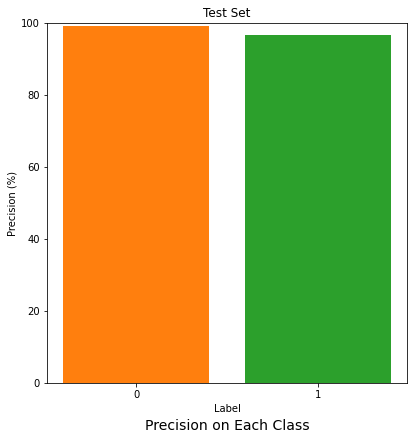

pre_test_list [99.03784477 96.57878217]


In [ ]:
pre_test_list = cal_precision_class(model, X_test, y_test, predicted_list_test)*100
plot_pre_class(pre_test_list)
print("pre_test_list", pre_test_list)

In [ ]:
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))
print(len(y_train))

X_train.shape = (22064, 10, 52)
y_train.shape = (22064, 2)
X_val.shape = (3152, 10, 52)
y_val.shape = (3152, 2)
X_test.shape = (6304, 10, 52)
y_test.shape = (6304, 2)
22064


# RECALL OF EACH CLASS

In [ ]:
def cal_recall_class(model, data_x, data_y, predicted_list):
    re_list = []
    for c in [[0, 1], [1, 0]]:
        TP_count = 0
        FN_count = 0
        for i in range(len(data_y)):
          TP_count += ((list(data_y[i]) == c) and (list(predicted_list[i]) == c)) #TP
          FN_count += ((list(data_y[i]) == c) and (list(predicted_list[i]) != c))     #FN
        re_list.append(TP_count/(TP_count+FN_count))
    return np.array(re_list)

In [ ]:
def plot_re_class( acc_test_list):

    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Recall (%)', ylim=(0, 100))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(5, 5))

    NUM_CLASS = 2
    # plot Recall for test set
    axes.bar(np.arange(NUM_CLASS), acc_test_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes.set_title('Test Set')

    fig.suptitle("Recall on Each Class", y=-0.1, fontsize=14)

    plt.show()

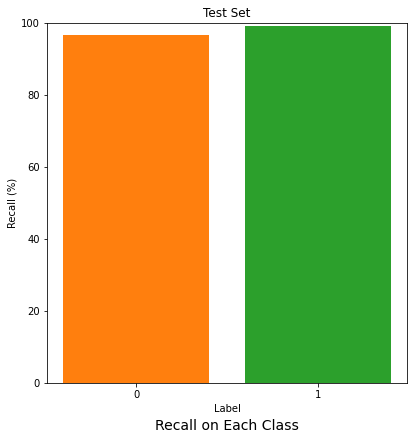

re_test_list [96.59055364 99.03443836]


In [ ]:
re_test_list = cal_recall_class(model, X_test, y_test, predicted_list_test)*100
plot_re_class(re_test_list)
print("re_test_list", re_test_list)

# F1 SCORE OF EACH CLASS

In [ ]:
def cal_f1_score_class(model, data_x, data_y, predicted_list):
  f1_score_list = []
  precision_list = cal_precision_class(model, X_test, y_test, predicted_list_test)*100
  recall_list = cal_recall_class(model, X_test, y_test, predicted_list_test)*100
  Num_Class = 2
  f1_score = 0
  for i in range(Num_Class):
    f1_score = 2*precision_list[i]*recall_list[i] / (precision_list[i]+recall_list[i])
    f1_score_list.append(f1_score)
  return np.array(f1_score_list)

In [ ]:
def plot_f1_score_class(acc_test_list):

    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Recall (%)', ylim=(0, 100))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(5, 5))

    NUM_CLASS = 2
    # plot Recall for test set
    axes.bar(np.arange(NUM_CLASS), acc_test_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes.set_title('Test Set')

    fig.suptitle("F1 score on Each Class", y=-0.1, fontsize=14)

    plt.show()

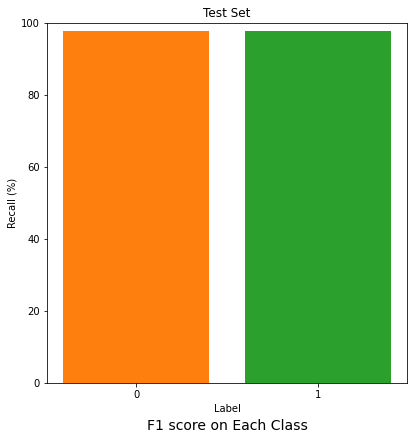

f1_score_test_list [97.79889153 97.79119657]


In [ ]:
f1_score_test_list = cal_f1_score_class(model, X_test, y_test, predicted_list_test)
plot_f1_score_class(f1_score_test_list)
print("f1_score_test_list", f1_score_test_list)

In [ ]:
a = [5, 7, 8, 10, 6, 12]
print(max(a))

12


In [ ]:
for j in range(, len(a)):
  print(a[j])

10
6
12
